In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [31]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
210101,R.MDKVHSEAER.L,QQKVLQQRMDKVHSE,KVHSEAERLEARFQD,VLQQRMDKVHSEAER,-,sp|Q96M63|CC114_HUMAN,MDKVHSEAER,0


In [51]:
def get_data(df):
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYVZ'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq] + [[0]*21]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               for seq in df.En.values]
    ec_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               if seq != '-' else [[0]*21 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               if seq != '-' else [[0]*21 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [54]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data(train)

aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data(val)

aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data(test)

In [55]:
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)

print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)

print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(215352, 40) (215352, 30, 21) (215352, 15, 21) (215352, 15, 21) (215352, 15, 21) (215352, 15, 21) (215352,)
(53838, 40) (53838, 30, 21) (53838, 15, 21) (53838, 15, 21) (53838, 15, 21) (53838, 15, 21) (53838,)
(67298, 40) (67298, 30, 21) (67298, 15, 21) (67298, 15, 21) (67298, 15, 21) (67298, 15, 21) (67298,)


# Train

In [8]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*8)])
    except RuntimeError as e:
        print(e)

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [57]:
input1 = tf.keras.layers.Input(shape=((30,21,)))  # peptide with zero padding
input2 = tf.keras.layers.Input(shape=((40,)))  # peptide info
input3 = tf.keras.layers.Input(shape=((15,21,)))  # N term info
input4 = tf.keras.layers.Input(shape=((15,21,)))  # C term info
input5 = tf.keras.layers.Input(shape=((15,21,)))  # miss1 term info
input6 = tf.keras.layers.Input(shape=((15,21,)))  # miss2 term info

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(input1)
net_lstm = tf.keras.layers.Dense(32, activation='relu')(lstm1)

net_dense1 = tf.keras.layers.Dense(32, activation='relu')(input2)
net_dense2 = tf.keras.layers.Dense(16, activation='relu')(net_dense1)

digest_n = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input3)
net_n = tf.keras.layers.Dense(16, activation='relu')(digest_n)
digest_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input4)
net_c = tf.keras.layers.Dense(16, activation='relu')(digest_c)
digest_m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input5)
net_m1 = tf.keras.layers.Dense(16, activation='relu')(digest_m1)
digest_m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input6)
net_m2 = tf.keras.layers.Dense(16, activation='relu')(digest_m2)

merge = tf.keras.layers.concatenate([net_lstm, 
                                     net_dense2,
                                    digest_n,
                                    digest_c,
                                    digest_m1,
                                    digest_m2])

net1 = tf.keras.layers.Dense(128, activation='relu')(merge)
net2 = tf.keras.layers.Dense(64, activation='relu')(net1)
net3 = tf.keras.layers.Dense(32, activation='relu')(net2)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net3)

model = tf.keras.Model(inputs=[input1, input2,
                              input3, input4,
                              input5, input6],
                       outputs=[output])

model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=100)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 30, 21)]     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 64)           13824       input_7[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 32)           1312        input_8[0][0]                    
____________________________________________________________________________________________

In [58]:
history = model.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=250,
                    batch_size=100,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es])

Epoch 1/250
2154/2154 [==============================] - 51s 18ms/step - loss: 0.6688 - accuracy: 0.6139 - val_loss: 0.5988 - val_accuracy: 0.7140
Epoch 2/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.5745 - accuracy: 0.7274 - val_loss: 0.5156 - val_accuracy: 0.7571
Epoch 3/250
2154/2154 [==============================] - 38s 18ms/step - loss: 0.5112 - accuracy: 0.7581 - val_loss: 0.4996 - val_accuracy: 0.7632
Epoch 4/250
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4979 - accuracy: 0.7653 - val_loss: 0.4894 - val_accuracy: 0.7669
Epoch 5/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4885 - accuracy: 0.7687 - val_loss: 0.4897 - val_accuracy: 0.7671
Epoch 6/250
2154/2154 [==============================] - 38s 18ms/step - loss: 0.4840 - accuracy: 0.7684 - val_loss: 0.4799 - val_accuracy: 0.7689
Epoch 7/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4777 - accuracy: 0.7718 - val_loss: 0

2154/2154 [==============================] - 37s 17ms/step - loss: 0.4142 - accuracy: 0.8095 - val_loss: 0.4169 - val_accuracy: 0.8069
Epoch 57/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4152 - accuracy: 0.8088 - val_loss: 0.4174 - val_accuracy: 0.8070
Epoch 58/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4136 - accuracy: 0.8099 - val_loss: 0.4162 - val_accuracy: 0.8070
Epoch 59/250
2154/2154 [==============================] - 38s 18ms/step - loss: 0.4154 - accuracy: 0.8086 - val_loss: 0.4172 - val_accuracy: 0.8072
Epoch 60/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4158 - accuracy: 0.8078 - val_loss: 0.4162 - val_accuracy: 0.8074
Epoch 61/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4151 - accuracy: 0.8083 - val_loss: 0.4156 - val_accuracy: 0.8069
Epoch 62/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4152 - accuracy: 0.8082 - val_loss: 0.4159 

2154/2154 [==============================] - 37s 17ms/step - loss: 0.4022 - accuracy: 0.8166 - val_loss: 0.4086 - val_accuracy: 0.8119
Epoch 112/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4027 - accuracy: 0.8163 - val_loss: 0.4085 - val_accuracy: 0.8121
Epoch 113/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4045 - accuracy: 0.8153 - val_loss: 0.4100 - val_accuracy: 0.8131
Epoch 114/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4035 - accuracy: 0.8161 - val_loss: 0.4068 - val_accuracy: 0.8133
Epoch 115/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4049 - accuracy: 0.8145 - val_loss: 0.4066 - val_accuracy: 0.8136
Epoch 116/250
2154/2154 [==============================] - 38s 18ms/step - loss: 0.4025 - accuracy: 0.8159 - val_loss: 0.4160 - val_accuracy: 0.8086
Epoch 117/250
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4043 - accuracy: 0.8152 - val_loss: 0

2154/2154 [==============================] - 39s 18ms/step - loss: 0.3949 - accuracy: 0.8202 - val_loss: 0.4081 - val_accuracy: 0.8138
Epoch 167/250
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3938 - accuracy: 0.8209 - val_loss: 0.4043 - val_accuracy: 0.8150
Epoch 168/250
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3946 - accuracy: 0.8208 - val_loss: 0.4008 - val_accuracy: 0.8164
Epoch 169/250
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3964 - accuracy: 0.8192 - val_loss: 0.4008 - val_accuracy: 0.8173
Epoch 170/250
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3946 - accuracy: 0.8210 - val_loss: 0.4003 - val_accuracy: 0.8180
Epoch 171/250
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3945 - accuracy: 0.8198 - val_loss: 0.4001 - val_accuracy: 0.8189
Epoch 172/250
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3927 - accuracy: 0.8209 - val_loss: 0

2154/2154 [==============================] - 39s 18ms/step - loss: 0.3909 - accuracy: 0.8231 - val_loss: 0.4031 - val_accuracy: 0.8154
Epoch 222/250
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3906 - accuracy: 0.8225 - val_loss: 0.3983 - val_accuracy: 0.8185
Epoch 223/250
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3908 - accuracy: 0.8218 - val_loss: 0.3958 - val_accuracy: 0.8205
Epoch 224/250
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3861 - accuracy: 0.8245 - val_loss: 0.3989 - val_accuracy: 0.8187
Epoch 225/250
2154/2154 [==============================] - 40s 18ms/step - loss: 0.3896 - accuracy: 0.8223 - val_loss: 0.3960 - val_accuracy: 0.8211
Epoch 226/250
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3862 - accuracy: 0.8253 - val_loss: 0.3955 - val_accuracy: 0.8218
Epoch 227/250
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3899 - accuracy: 0.8225 - val_loss: 0

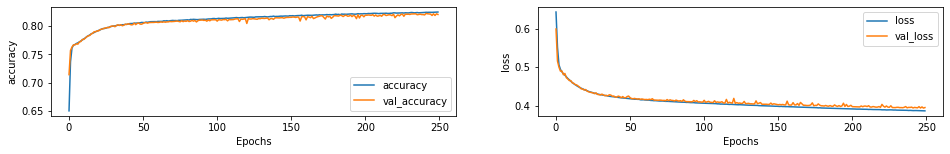

In [59]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

2104/2104 [==============================] - 14s 7ms/step - loss: 0.3917 - accuracy: 0.8219
Test Loss: 0.39168938994407654
Test Accuracy: 0.8218520879745483
              precision    recall  f1-score   support

           0       0.85      0.79      0.82     33706
           1       0.80      0.86      0.83     33592

    accuracy                           0.82     67298
   macro avg       0.82      0.82      0.82     67298
weighted avg       0.82      0.82      0.82     67298

rf auc : 0.9042069017338289


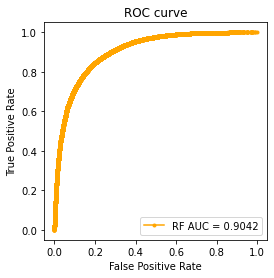

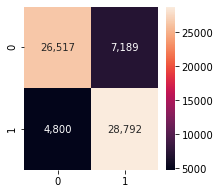

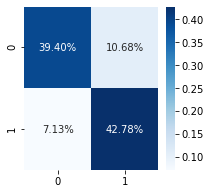

In [60]:
test_loss, test_acc = model.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# high epoch

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 30, 21)]     0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
bidirectional_20 (Bidirectional (None, 64)           13824       input_25[0][0]                   
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 32)           1312        input_26[0][0]                   
____________________________________________________________________________________________

2154/2154 [==============================] - 39s 18ms/step - loss: 0.4361 - accuracy: 0.7957 - val_loss: 0.4331 - val_accuracy: 0.7979
Epoch 25/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4336 - accuracy: 0.7975 - val_loss: 0.4330 - val_accuracy: 0.7988
Epoch 26/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4329 - accuracy: 0.7987 - val_loss: 0.4352 - val_accuracy: 0.7957
Epoch 27/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4354 - accuracy: 0.7960 - val_loss: 0.4305 - val_accuracy: 0.7993
Epoch 28/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4295 - accuracy: 0.8000 - val_loss: 0.4305 - val_accuracy: 0.7987
Epoch 29/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4314 - accuracy: 0.7989 - val_loss: 0.4348 - val_accuracy: 0.7973
Epoch 30/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4259 - accuracy: 0.8022 - val_loss: 0

2154/2154 [==============================] - 39s 18ms/step - loss: 0.4096 - accuracy: 0.8125 - val_loss: 0.4170 - val_accuracy: 0.8076
Epoch 80/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4093 - accuracy: 0.8131 - val_loss: 0.4116 - val_accuracy: 0.8113
Epoch 81/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4081 - accuracy: 0.8119 - val_loss: 0.4137 - val_accuracy: 0.8100
Epoch 82/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4089 - accuracy: 0.8124 - val_loss: 0.4111 - val_accuracy: 0.8113
Epoch 83/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4101 - accuracy: 0.8101 - val_loss: 0.4104 - val_accuracy: 0.8114
Epoch 84/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4073 - accuracy: 0.8131 - val_loss: 0.4109 - val_accuracy: 0.8112
Epoch 85/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.4098 - accuracy: 0.8123 - val_loss: 0

Epoch 134/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3969 - accuracy: 0.8187 - val_loss: 0.4074 - val_accuracy: 0.8143
Epoch 135/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3972 - accuracy: 0.8184 - val_loss: 0.4036 - val_accuracy: 0.8162
Epoch 136/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3995 - accuracy: 0.8170 - val_loss: 0.4052 - val_accuracy: 0.8154
Epoch 137/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.4000 - accuracy: 0.8179 - val_loss: 0.4034 - val_accuracy: 0.8163
Epoch 138/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3990 - accuracy: 0.8185 - val_loss: 0.4033 - val_accuracy: 0.8162
Epoch 139/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.4011 - accuracy: 0.8171 - val_loss: 0.4063 - val_accuracy: 0.8133
Epoch 140/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3992 - accuracy:

2154/2154 [==============================] - 39s 18ms/step - loss: 0.3924 - accuracy: 0.8216 - val_loss: 0.3981 - val_accuracy: 0.8196
Epoch 189/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3909 - accuracy: 0.8224 - val_loss: 0.3974 - val_accuracy: 0.8190
Epoch 190/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3926 - accuracy: 0.8219 - val_loss: 0.3976 - val_accuracy: 0.8195
Epoch 191/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3914 - accuracy: 0.8215 - val_loss: 0.3984 - val_accuracy: 0.8195
Epoch 192/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3914 - accuracy: 0.8222 - val_loss: 0.3973 - val_accuracy: 0.8194
Epoch 193/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3924 - accuracy: 0.8216 - val_loss: 0.3974 - val_accuracy: 0.8188
Epoch 194/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3903 - accuracy: 0.8231 - val_l

Epoch 243/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3855 - accuracy: 0.8255 - val_loss: 0.3935 - val_accuracy: 0.8221
Epoch 244/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3855 - accuracy: 0.8252 - val_loss: 0.3927 - val_accuracy: 0.8222
Epoch 245/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3858 - accuracy: 0.8258 - val_loss: 0.3925 - val_accuracy: 0.8220
Epoch 246/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3871 - accuracy: 0.8246 - val_loss: 0.3929 - val_accuracy: 0.8223
Epoch 247/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3843 - accuracy: 0.8267 - val_loss: 0.3938 - val_accuracy: 0.8217
Epoch 248/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3838 - accuracy: 0.8268 - val_loss: 0.3980 - val_accuracy: 0.8182
Epoch 249/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3842 - accuracy:

2154/2154 [==============================] - 38s 18ms/step - loss: 0.3809 - accuracy: 0.8278 - val_loss: 0.3899 - val_accuracy: 0.8248
Epoch 298/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3826 - accuracy: 0.8265 - val_loss: 0.3932 - val_accuracy: 0.8216
Epoch 299/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3814 - accuracy: 0.8283 - val_loss: 0.3899 - val_accuracy: 0.8237
Epoch 300/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3797 - accuracy: 0.8289 - val_loss: 0.3896 - val_accuracy: 0.8250
Epoch 301/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3787 - accuracy: 0.8287 - val_loss: 0.3971 - val_accuracy: 0.8222
Epoch 302/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3815 - accuracy: 0.8282 - val_loss: 0.3906 - val_accuracy: 0.8232
Epoch 303/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3805 - accuracy: 0.8288 - val_l

Epoch 352/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3804 - accuracy: 0.8288 - val_loss: 0.3890 - val_accuracy: 0.8260
Epoch 353/1500
2154/2154 [==============================] - 40s 19ms/step - loss: 0.3791 - accuracy: 0.8300 - val_loss: 0.3879 - val_accuracy: 0.8250
Epoch 354/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3762 - accuracy: 0.8304 - val_loss: 0.3895 - val_accuracy: 0.8248
Epoch 355/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3774 - accuracy: 0.8306 - val_loss: 0.3874 - val_accuracy: 0.8246
Epoch 356/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3785 - accuracy: 0.8293 - val_loss: 0.3878 - val_accuracy: 0.8253
Epoch 357/1500
2154/2154 [==============================] - 40s 18ms/step - loss: 0.3770 - accuracy: 0.8313 - val_loss: 0.3878 - val_accuracy: 0.8256
Epoch 358/1500
2154/2154 [==============================] - 39s 18ms/step - loss: 0.3766 - accuracy:

2154/2154 [==============================] - 38s 17ms/step - loss: 0.3775 - accuracy: 0.8299 - val_loss: 0.3858 - val_accuracy: 0.8262
Epoch 407/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3749 - accuracy: 0.8310 - val_loss: 0.3858 - val_accuracy: 0.8257
Epoch 408/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3750 - accuracy: 0.8310 - val_loss: 0.3894 - val_accuracy: 0.8266
Epoch 409/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3757 - accuracy: 0.8310 - val_loss: 0.3869 - val_accuracy: 0.8265
Epoch 410/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3769 - accuracy: 0.8300 - val_loss: 0.3872 - val_accuracy: 0.8269
Epoch 411/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3750 - accuracy: 0.8311 - val_loss: 0.3857 - val_accuracy: 0.8265
Epoch 412/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3752 - accuracy: 0.8315 - val_l

Epoch 461/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3728 - accuracy: 0.8325 - val_loss: 0.3845 - val_accuracy: 0.8269
Epoch 462/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3708 - accuracy: 0.8326 - val_loss: 0.3855 - val_accuracy: 0.8283
Epoch 463/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3722 - accuracy: 0.8328 - val_loss: 0.3844 - val_accuracy: 0.8274
Epoch 464/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3726 - accuracy: 0.8324 - val_loss: 0.3853 - val_accuracy: 0.8275
Epoch 465/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3740 - accuracy: 0.8321 - val_loss: 0.3866 - val_accuracy: 0.8276
Epoch 466/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3729 - accuracy: 0.8326 - val_loss: 0.3844 - val_accuracy: 0.8276
Epoch 467/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3752 - accuracy:

2154/2154 [==============================] - 38s 17ms/step - loss: 0.3708 - accuracy: 0.8338 - val_loss: 0.3836 - val_accuracy: 0.8278
Epoch 516/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3700 - accuracy: 0.8345 - val_loss: 0.3855 - val_accuracy: 0.8285
Epoch 517/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3691 - accuracy: 0.8343 - val_loss: 0.3839 - val_accuracy: 0.8278
Epoch 518/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3698 - accuracy: 0.8346 - val_loss: 0.3866 - val_accuracy: 0.8279
Epoch 519/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3686 - accuracy: 0.8348 - val_loss: 0.3854 - val_accuracy: 0.8270
Epoch 520/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3698 - accuracy: 0.8344 - val_loss: 0.3833 - val_accuracy: 0.8286
Epoch 521/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3696 - accuracy: 0.8334 - val_l

Epoch 570/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3680 - accuracy: 0.8350 - val_loss: 0.3833 - val_accuracy: 0.8294
Epoch 571/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3700 - accuracy: 0.8338 - val_loss: 0.3831 - val_accuracy: 0.8280
Epoch 572/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3692 - accuracy: 0.8343 - val_loss: 0.3824 - val_accuracy: 0.8293
Epoch 573/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3688 - accuracy: 0.8345 - val_loss: 0.3826 - val_accuracy: 0.8289
Epoch 574/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3661 - accuracy: 0.8357 - val_loss: 0.3832 - val_accuracy: 0.8282
Epoch 575/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3659 - accuracy: 0.8369 - val_loss: 0.3825 - val_accuracy: 0.8287
Epoch 576/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3684 - accuracy:

2154/2154 [==============================] - 38s 17ms/step - loss: 0.3659 - accuracy: 0.8352 - val_loss: 0.3889 - val_accuracy: 0.8246
Epoch 625/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3641 - accuracy: 0.8373 - val_loss: 0.3824 - val_accuracy: 0.8296
Epoch 626/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3646 - accuracy: 0.8378 - val_loss: 0.3826 - val_accuracy: 0.8289
Epoch 627/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3653 - accuracy: 0.8361 - val_loss: 0.3832 - val_accuracy: 0.8294
Epoch 628/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3646 - accuracy: 0.8369 - val_loss: 0.3876 - val_accuracy: 0.8275
Epoch 629/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3670 - accuracy: 0.8364 - val_loss: 0.3843 - val_accuracy: 0.8298
Epoch 630/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3668 - accuracy: 0.8356 - val_l

Epoch 679/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3645 - accuracy: 0.8373 - val_loss: 0.3815 - val_accuracy: 0.8300
Epoch 680/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3629 - accuracy: 0.8386 - val_loss: 0.3815 - val_accuracy: 0.8299
Epoch 681/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3650 - accuracy: 0.8374 - val_loss: 0.3818 - val_accuracy: 0.8288
Epoch 682/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3637 - accuracy: 0.8369 - val_loss: 0.3825 - val_accuracy: 0.8286
Epoch 683/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3641 - accuracy: 0.8370 - val_loss: 0.3823 - val_accuracy: 0.8289
Epoch 684/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3620 - accuracy: 0.8377 - val_loss: 0.3824 - val_accuracy: 0.8298
Epoch 685/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3661 - accuracy:

2154/2154 [==============================] - 38s 18ms/step - loss: 0.3617 - accuracy: 0.8392 - val_loss: 0.3818 - val_accuracy: 0.8302
Epoch 734/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3622 - accuracy: 0.8393 - val_loss: 0.3811 - val_accuracy: 0.8300
Epoch 735/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3628 - accuracy: 0.8381 - val_loss: 0.3810 - val_accuracy: 0.8305
Epoch 736/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3625 - accuracy: 0.8373 - val_loss: 0.3810 - val_accuracy: 0.8297
Epoch 737/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3615 - accuracy: 0.8386 - val_loss: 0.3833 - val_accuracy: 0.8300
Epoch 738/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3613 - accuracy: 0.8396 - val_loss: 0.3845 - val_accuracy: 0.8279
Epoch 739/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3602 - accuracy: 0.8385 - val_l

Epoch 788/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3598 - accuracy: 0.8397 - val_loss: 0.3808 - val_accuracy: 0.8306
Epoch 789/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3600 - accuracy: 0.8394 - val_loss: 0.3807 - val_accuracy: 0.8308
Epoch 790/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3598 - accuracy: 0.8397 - val_loss: 0.3812 - val_accuracy: 0.8303
Epoch 791/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3608 - accuracy: 0.8387 - val_loss: 0.3809 - val_accuracy: 0.8298
Epoch 792/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3587 - accuracy: 0.8386 - val_loss: 0.3809 - val_accuracy: 0.8307
Epoch 793/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3602 - accuracy: 0.8395 - val_loss: 0.3806 - val_accuracy: 0.8304
Epoch 794/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3590 - accuracy:

2154/2154 [==============================] - 38s 18ms/step - loss: 0.3582 - accuracy: 0.8409 - val_loss: 0.3811 - val_accuracy: 0.8304
Epoch 843/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3589 - accuracy: 0.8402 - val_loss: 0.3804 - val_accuracy: 0.8310
Epoch 844/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3574 - accuracy: 0.8412 - val_loss: 0.3808 - val_accuracy: 0.8312
Epoch 845/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3569 - accuracy: 0.8409 - val_loss: 0.3813 - val_accuracy: 0.8299
Epoch 846/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3577 - accuracy: 0.8411 - val_loss: 0.3819 - val_accuracy: 0.8292
Epoch 847/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3568 - accuracy: 0.8411 - val_loss: 0.3808 - val_accuracy: 0.8304
Epoch 848/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3565 - accuracy: 0.8414 - val_l

Epoch 897/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3544 - accuracy: 0.8430 - val_loss: 0.3829 - val_accuracy: 0.8287
Epoch 898/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3573 - accuracy: 0.8413 - val_loss: 0.3807 - val_accuracy: 0.8317
Epoch 899/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3576 - accuracy: 0.8405 - val_loss: 0.3802 - val_accuracy: 0.8306
Epoch 900/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3559 - accuracy: 0.8424 - val_loss: 0.3802 - val_accuracy: 0.8307
Epoch 901/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3553 - accuracy: 0.8419 - val_loss: 0.3807 - val_accuracy: 0.8307
Epoch 902/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3563 - accuracy: 0.8420 - val_loss: 0.3805 - val_accuracy: 0.8316
Epoch 903/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3545 - accuracy:

2154/2154 [==============================] - 38s 18ms/step - loss: 0.3555 - accuracy: 0.8422 - val_loss: 0.3810 - val_accuracy: 0.8312
Epoch 952/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3553 - accuracy: 0.8428 - val_loss: 0.3817 - val_accuracy: 0.8308
Epoch 953/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3542 - accuracy: 0.8440 - val_loss: 0.3810 - val_accuracy: 0.8312
Epoch 954/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3540 - accuracy: 0.8437 - val_loss: 0.3821 - val_accuracy: 0.8299
Epoch 955/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3541 - accuracy: 0.8429 - val_loss: 0.3807 - val_accuracy: 0.8313
Epoch 956/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3559 - accuracy: 0.8421 - val_loss: 0.3833 - val_accuracy: 0.8291
Epoch 957/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3532 - accuracy: 0.8432 - val_l

2154/2154 [==============================] - 37s 17ms/step - loss: 0.3521 - accuracy: 0.8438 - val_loss: 0.3841 - val_accuracy: 0.8287
Epoch 1006/1500
2154/2154 [==============================] - 37s 17ms/step - loss: 0.3517 - accuracy: 0.8441 - val_loss: 0.3821 - val_accuracy: 0.8295
Epoch 1007/1500
2154/2154 [==============================] - 38s 18ms/step - loss: 0.3527 - accuracy: 0.8442 - val_loss: 0.3814 - val_accuracy: 0.8308
Epoch 1008/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3511 - accuracy: 0.8444 - val_loss: 0.3830 - val_accuracy: 0.8302
Epoch 1009/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3520 - accuracy: 0.8446 - val_loss: 0.3811 - val_accuracy: 0.8310
Epoch 1010/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3517 - accuracy: 0.8449 - val_loss: 0.3811 - val_accuracy: 0.8314
Epoch 1011/1500
2154/2154 [==============================] - 38s 17ms/step - loss: 0.3534 - accuracy: 0.8446 -

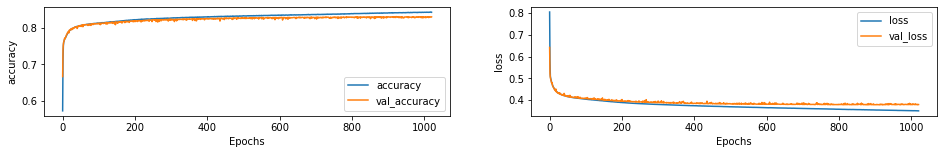

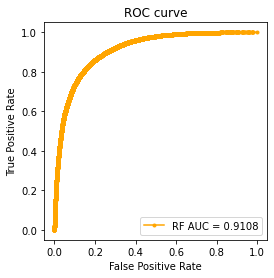

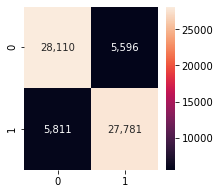

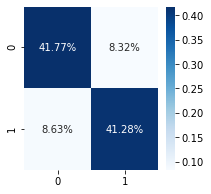

In [66]:
input1 = tf.keras.layers.Input(shape=((30,21,)))  # peptide with zero padding
input2 = tf.keras.layers.Input(shape=((40,)))  # peptide info
input3 = tf.keras.layers.Input(shape=((15,21,)))  # N term info
input4 = tf.keras.layers.Input(shape=((15,21,)))  # C term info
input5 = tf.keras.layers.Input(shape=((15,21,)))  # miss1 term info
input6 = tf.keras.layers.Input(shape=((15,21,)))  # miss2 term info

lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(input1)
net_lstm = tf.keras.layers.Dense(32, activation='relu')(lstm1)

net_dense1 = tf.keras.layers.Dense(32, activation='relu')(input2)
net_dense2 = tf.keras.layers.Dense(16, activation='relu')(net_dense1)

digest_n = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input3)
net_n = tf.keras.layers.Dense(16, activation='relu')(digest_n)
digest_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input4)
net_c = tf.keras.layers.Dense(16, activation='relu')(digest_c)
digest_m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input5)
net_m1 = tf.keras.layers.Dense(16, activation='relu')(digest_m1)
digest_m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input6)
net_m2 = tf.keras.layers.Dense(16, activation='relu')(digest_m2)

merge = tf.keras.layers.concatenate([net_lstm, 
                                     net_dense2,
                                    digest_n,
                                    digest_c,
                                    digest_m1,
                                    digest_m2])

net1 = tf.keras.layers.Dense(128, activation='relu')(merge)
net2 = tf.keras.layers.Dense(64, activation='relu')(net1)
net3 = tf.keras.layers.Dense(32, activation='relu')(net2)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net3)

model2 = tf.keras.Model(inputs=[input1, input2,
                              input3, input4,
                              input5, input6],
                       outputs=[output])

model2.summary()

model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=100)

history = model2.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=1500,
                    batch_size=100,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es])

plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

test_loss, test_acc = model2.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model2.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model2.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model2
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()